In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_hpw as utils
import pymc3 as pm
import theano.tensor as tt
from scipy import stats 
from IPython.display import Image 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# enzymeBayes 

Final project for Alp Kucukelbir's Machine Learning Probabilistic Programming (COMS6998) by Jiayu Zhang and Kiran Gauthier. 

### Familiarizing ourselves with the data 

All data in this analysis has been graciously provided by Prof. Jennifer Ross, Mengqi Xu, and their collaborators from their paper [Direct Single Molecule Imaging of Enhanced Enzyme Diffusion](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.128101) and is available upon request. In recent literature, see [Butler et. al (2010)](https://pubs.acs.org/doi/10.1021/ja908773a) and [Börsch et. al (2018)](https://pubs.acs.org/doi/10.1021/acs.accounts.8b00276), it has been shown that enzymes may diffuse faster when they are in the presence of their substrate in a process now known as enhanced diffusion. However, it has been shown that there are artifacts due to environmental conditions in fluoresence correlation spectroscopy (FCS), which is the main imaging technique of these enzymes (which are roughly 5-10 nanometers in diameter), casting doubt on previous experimental results. In this work, urease enzymes were imaged using a novel technique of direct single molecule imaging which is less sentitive to intensity fluctuations and can provide an accurate estimate of the diffusion coefficient from the trajectory alone. 

Shown below in [Figure 1.(a)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.128101) is the single imaging setup used in experiment. We will forgo most of the technical details in favor of speaking to the the implications of this setup.

<!-- !['Figure 1.(a)](singleMoleculeImaging.png){ width: 50% } --> 
<img src="singleMoleculeImaging.png" width="400" height="400">

The experimental cell is prepared with a surfactant (Pluornic F127) to block the urease enzymes from sticking to the coverglass and methylcellulose is added as a viscous agent to slow down the diffusion as the total internal reflection fluorescence (TIRF) imaging technique can only detect particles within $300 nm$ of the surface, effectively imaging the $3D$ cell in a $2D$ plane. 

Shown below are a representative trajectories from the buffer dataset (i.e. no urea).

In [14]:
# dir_ = 'new_data/transformed_buffer/'
dir_ = 'mengqi_buffer/'
x, y, t, track_info, lookup, track_id = utils.loadRawMinData(dir_, min_length=5, isDx=False)
x, y, t, dx, dy, dt, lookup, track_info = utils.removeAllOutliers(x, y, t, track_info)

Total 15 files read; Total 813 trajectories (length >= 5) loaded; Total 23909 data points


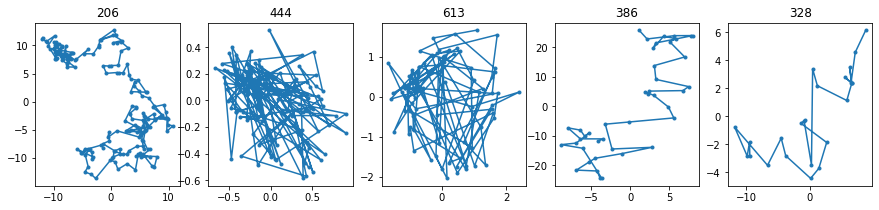

In [15]:
sel_ind = [206, 444, 613, 386, 328]
utils.manyplots_real(1, 5, sel_ind, track_info, [x, y, t])

From this representative dataset, we would like to communicate certain trends to the reader, 
1. enzymes can exist in the frame of view for varying lengths of time 
2. there are quantitative differences between the lengths over which particles diffuse, some are on the order of a pixel while others can be over many tens of pixels before they fall out of focus 
3. the videos for which these particle trajectories were extracted could be noisy, although the enzymes are assumed to be labeled fluorescently to a ratio of one fluophore per monomer on average, certain enzymes may have more fluorescent tags 

which we must factor into our modeling of the system. 

## Box's Loop 

### Simple Brownian Diffusion model 

We begin our first iteration of Box's loop, shown below. 

<img src="boxsLoop.png" width="300" height="300"> 

#### Modeling 
In the modeling stage, we assume that the data can be analyzed by the simplest possible model, *Brownian diffusion* (BD). Derivation for this, and separate models, are given in **XXX** helper notebook. 

#### Inference
Assuming an inverse gamma prior for the diffusion coefficient, one can derive the posterior analytically and the posterior results are plotted below for all 813 trajectories. 

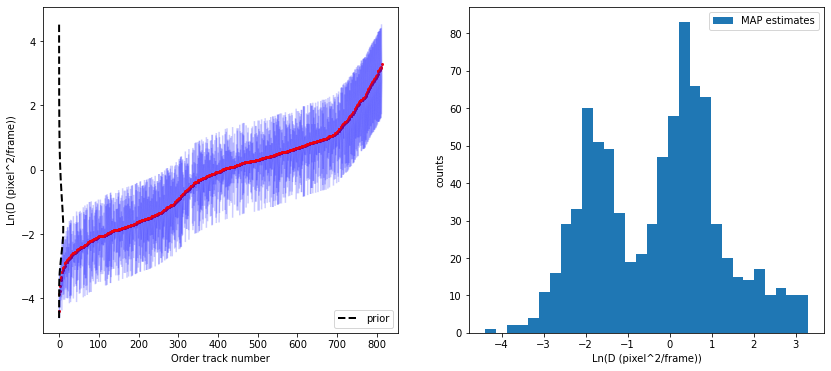

In [16]:
utils.draw_vertical_posterior_bm([dx, dy, dt], 0.25, 0.2, track_info)

#### Criticism  

From the analytic inference of the proposed model, there are two points we would like to address in the criticism stage, 
1. there are a series of very short trajectories ($len \sim 5$) which are very uncertain, marked by the wide posterior trajectories in the left plot 
2. plotting the posterior mean of the diffusive trajectories in logspace, the distribution seems strongly bimodal, implying that there is a slowly diffusive population and a more quickly diffusive population 

This analysis disqualifies the simple Brownian diffusion model from analyzing this dataset as the enzyme trajectories are heterogeneous, implying that a single, simple diffusive model would not do well to characterize the population from which they were drawn from. See above for the slow, confined trajectories which appear blob like, and the larger diffusive trajectories for which a more certain estimate of the diffusion coefficient can be derived. 

From this initial iteration of Box's loop, we propose a new model through which we can analyze the observed data in which enzymes can "stick" to the surface, existing in a harmonic potential well. For this model, we can again recover an estimate of the diffusion coefficient but we can also recover an estimate of the strength of the potential well, which we denote $\lambda$. We will now perform another trip through Box's loop with this new model, the *Harmonic potential well* (HPW) model. 

### Harmonic Potential Well model 

#### Modeling 

Although initially not considered for the BD model, another important parameter in the analysis could be the measurement noise associated with tracking an individual particle. In this, we include three parameters for the harmonic potential well model, the diffusion coefficient, $D$, the potential well strength, $\lambda$, and the measurement noise, $M_e$. 

We then turned to simulating data as certain combinations of these parameters (say, small $D$, large $\lambda$, large $M_e$ or large $D$, small $\lambda$, small $M_e$) are difficult to recover in the inference stage. See below for examples of how the strength of the potential well and measurement noise can obscure diffusive trajectories. After careful validation that we could in fact recover the diffusion coefficient $D$ and potential well strength $\lambda$ for various configurations in the low noise (small $M_e$) regime, we turned to the experimental data. 

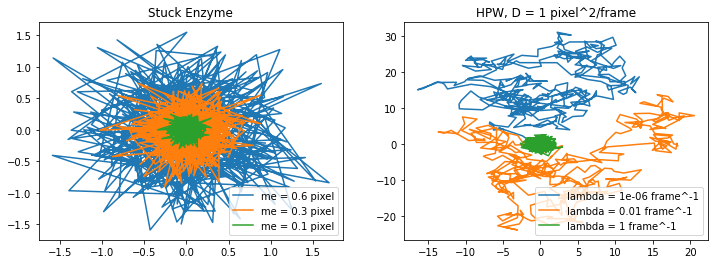

In [17]:
me = [0.6, 0.3, 0.1]
lambda_ = [1e-06, 0.01, 1]
n_times = 423
t_ = [i for i in range(n_times+1)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(me)): 
    x_, y_ = utils.simulate_stuck(me[i], n_times)
    hpw = utils.base_HPW_D([0, 0], t_, 1, [0, 0], lambda_[i])
    axes[0].plot(x_, y_, label='me = ' + str(me[i]) + ' pixel')
    np.random.seed(5555) 
    axes[1].plot(hpw[0], hpw[1], label='lambda = ' + str(lambda_[i]) + ' frame^-1' , )

axes[0].set_title('Stuck Enzyme')
axes[1].set_title('HPW, D = 1 pixel^2/frame')
axes[0].legend()
axes[1].legend();

In the figure shown above, the "confined" tracjectories seen in the data above could either be generated by large measurement noise (large $M_e$) or a strong potential well (large $\lambda$). We hope to resolve this bimodal structure of the posterior diffusion coefficient by sampling using the HPW model which may explain them more readily. 

#### Inference / Criticism 

##### Inference on $M_e$ 

We slightly rewrote the inferential HPW model to express the likelihood of a tracjectory in the absence of a potential well, (i.e. tracks for which $\lambda \sim 0$) and identified 10 tracks which were diffusive (i.e. non-confined) to sample over $D$ and $M_e$ alone. Five of the ten are plotted below. 

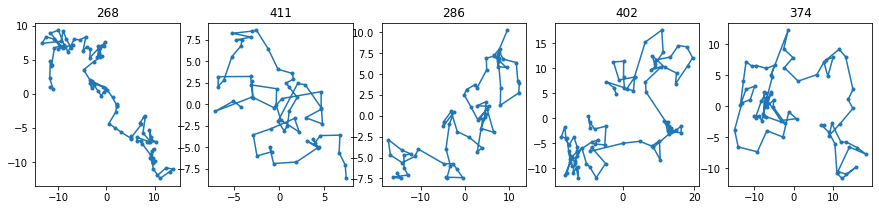

In [21]:
sel_ind = [268, 411, 286, 402, 374]
utils.manyplots_real(1, 5, sel_ind, track_info, [x, y, t])

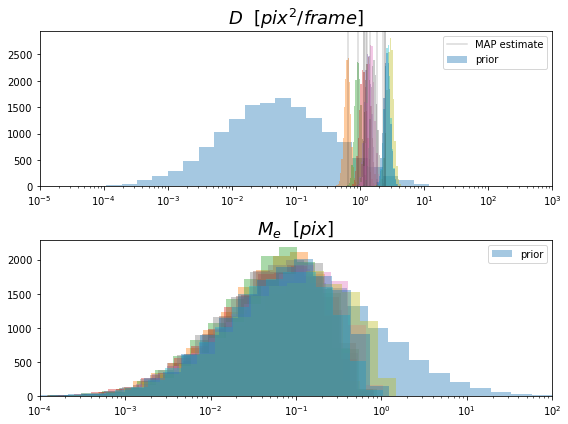

In [44]:
utils.plot_DMeAnalysis([dx, dy, dt, track_info])  

In this, and all below cases, we used the [No U-Turn Hamiltonian Monte Carlo](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf) sampler implemented in [PyMC3](https://docs.pymc.io/) for Python as it explored the low dimensional parameter set efficiently, all of which were continuous parameters. This is due to the fact that HMC+NUTS was able to leverage the gradient of the log joint density and converge much faster than other sampling methods, while also automatically tuning its sampling parameters. PyMC3 is built on Theano to analytically compute these model gradients through automatic differentiation of the log joint. 

From this, we plot the posterior of the diffusion coefficient, $D$, and the measurement noise, $M_e$, relative to the prior, which is lognormally distributed over many orders of magnitude. We note that we are able to confidently recover estimates of $D$, and to validate the assumption that these tracks are truly diffusive (with $\lambda \sim 0$) by overlaying the MAP estimate using the simple diffusive model alone. We see that these match well. 

Finally, we note that there is only a small likelhood that the measurement noise is on the scale of a pixel, with much larger probability mass on the subpixel scale. Due to the fact that the vast majority of our trajectories diffuse further than a pixel per timestep, we eliminate $M_e$ from the sampling entirely. 

#### Inference / Criticism 

##### Autocorrelation analysis 

We quickly realized that in order to deconvolve the final two parameters in the HPW model, the diffusion coefficient, $D$, and the potential well strength, $\lambda$, we must importantly consider their relative values to the time between sequential data points in a trajectory. For the analysis of this dataset where the framerate is $\sim 12 fps$ or, $\sim 0.08$ seconds per frame, the HPW model finds it difficult to converge when $\lambda$ is large relative to $D$, this point is illustrated by the autocorrelation analysis on simulated data below: 

In [45]:
lam_lis = np.linspace(1, 100, 15)
t_ = np.linspace(0, 8*3, 101*3)
_, x_lis, error_lis =  utils.auto_x_dx(0.175, lam_lis,  t_, 20, 1)

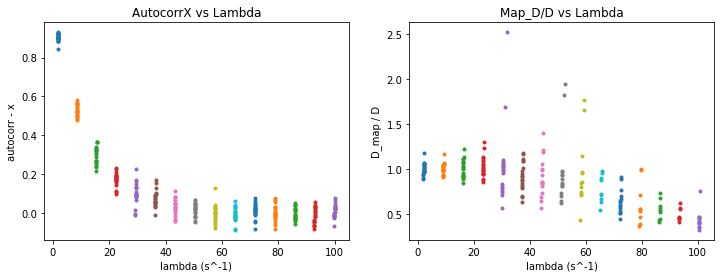

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(lam_lis)): 

    axes[0].plot(lam_lis[i] + x_lis[i], x_lis[i], '.')
    axes[1].plot(lam_lis[i]+ error_lis[i], error_lis[i], '.')

axes[0].set_title('AutocorrX vs Lambda')
axes[1].set_title('Map_D/D vs Lambda')
axes[0].set_xlabel('lambda (s^-1)')
axes[1].set_xlabel('lambda (s^-1)')
axes[0].set_ylabel('autocorr - x')
axes[1].set_ylabel('D_map / D');

From a high level view, when $\lambda$ is small relative to a fixed $D$, the track is largely diffusive, for which each sequential point in the trajectory shares large correlation with the previous point. This fits well with *Model 1: Brownian diffusion*. However, we see that with increasing values of $\lambda$, after say $\lambda \sim 20$, the autocorrelation is effectively zero, indicating that the well is so strong, each sequential position is simply sampled from a normal distribution, producing trajectories similar to the "stuck" case above. 

From the $MAP_D$ relative to the true $D$, we look to demonstrate the value of the HPW model on moderately confined tracks (i.e. for $\lambda < 20 s^{-1}$), where we assign less weight to strongly confined tracks for which we will not be able to converge at this framerate. 

In [47]:
## ADD IN THE POPULATION LEVEL DISCUSSION HERE TOMORROW WITH JIAYU 

#### Criticism

##### Posterior Predictive Checks (PPC) 

To further demonstrate the value of differentiating between these two models, we we will use PPCs with two different metrics to show why the simple BD model is not valid for describing the stuck enzyme population relative to the HPW model. 


We are going to use PPC with 2 different metrics to show that why the simple BM model and the Stuck enzyme model are not suitable for the confined population (as least part of them, since as the well strength increases, HPW model is essentially the same as stuck enzyme model). (GO THROUGH THIS SECTION WITH JIAYU) 

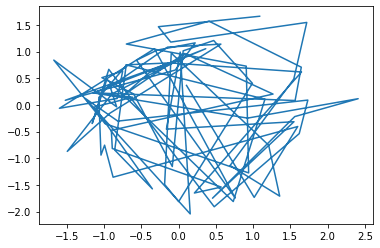

In [22]:
# track of interest
sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, 613, False)
sx, sy, st = utils.removeOutLiar(sx, sy, st)
sdx, sdy, sdt = sx[1:]-sx[:-1], sy[1:]-sy[:-1], st[1:]-st[:-1]
plt.plot(sx, sy);

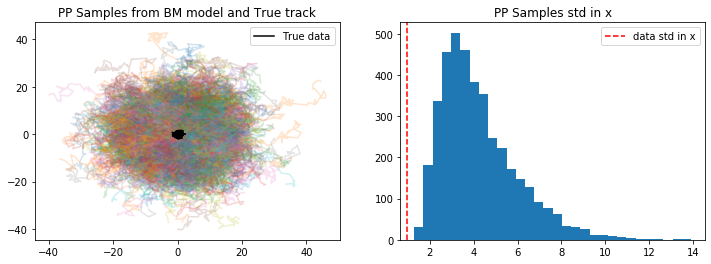

In [24]:
utils.PPCs([sx, sy, st, sdx, sdy, sdt], 'bm')

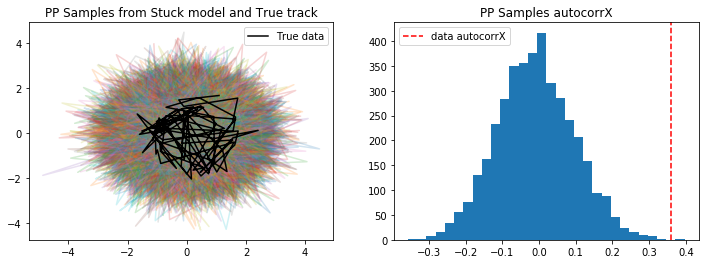

In [25]:
utils.PPCs([sx, sy, st, sdx, sdy, sdt], 'me')

For the bm model, we see that although it is able to infer the diffusion coefficient, the posterior samples don not at all resemble the true track. For the Stuck model, although the PP samples looks like the true track, the PPCs tells us that this model is not very likelihood for this specific track.